<a href="https://www.kaggle.com/code/yusefsavid/spaceship-titanic-1?scriptVersionId=116705672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.display import display_markdown
import os
display_markdown(f'''# Welcome to my {os.getenv('PYTHONPATH').split('/')[-1]} competition notebook
''', raw=True)

# Welcome to my spaceship-titanic competition notebook


## Install or update any packages needed

In [2]:
# !pip install headjackai-sdk
# !pip install --ignore-installed --pre pycaret

## Importing all that is needed

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV
from sklearn.metrics import log_loss,accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.experimental import enable_halving_search_cv 
import optuna
import xgboost as xgb
from tqdm.notebook import tqdm
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score,StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
# from pycaret.classification  import *
import os

INPUT = f"/kaggle/input/{os.getenv('PYTHONPATH').split('/')[-1]}/"
OUTPUT = "/kaggle/working/"


## Reading all datasets and some light analysis

In [4]:
train =  pd.read_csv(f"{INPUT}/train.csv")#.sample(frac=1).reset_index(drop=True)
test = pd.read_csv(f"{INPUT}/test.csv")#.sample(frac=1).reset_index(drop=True)
sample = pd.read_csv(f"{INPUT}/sample_submission.csv")
traintest = pd.concat([train,test], axis = 0).reset_index(drop=True)

In [5]:
traintest

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [6]:
traintest.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


In [8]:
sample 

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


### split columns that could be useful split

In [9]:
splitable = ["PassengerId" ,"Cabin", "Name"]
delimeters = ["_" , "/" , "-"," "]
# traintest = pd.concat([train,test], axis = 0).sample(frac=1).reset_index(drop=True)
for j,i in enumerate(splitable):
    traintest = pd.concat([traintest,traintest[i].str.split("|".join(delimeters),expand=True).add_prefix(f'{i}_')], axis = 1)
#     test = pd.concat([test,test[i].str.split(delimeters[j],expand=True).add_prefix(f'{i}_')], axis = 1) 
#     traintest.drop(i, axis= 1, inplace = True)
#     test.drop(i, axis= 1, inplace = True)
# traintest[list(set(traintest.columns) - set(["Transported"])) ] = traintest[list(set(traintest.columns) - set(["Transported"])) ].fillna(method = "bfill")

### Create new columns 

In [10]:
traintest["Expenses"] = traintest[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]].sum(axis = 1)

### CryoSleep

Check if there are rows where expenses is more than 0.0 while CryoSleep being True(should not happen)

In [11]:
traintest.query("CryoSleep == True and Expenses > 0.0")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses


<AxesSubplot:ylabel='CryoSleep'>

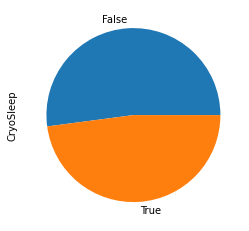

In [12]:
traintest.query("Age <= 13.0").CryoSleep.value_counts().plot.pie()

<AxesSubplot:ylabel='CryoSleep'>

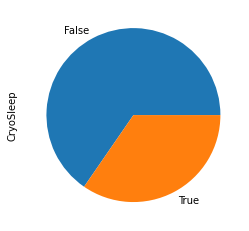

In [13]:
traintest.query("Age > 13.0").CryoSleep.value_counts().plot.pie()

The maximum expense for those with age 0 is :0.0


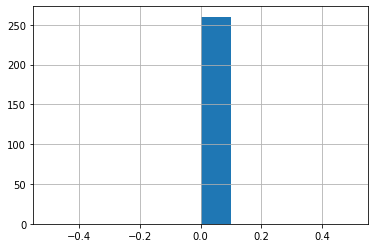

In [14]:
traintest.query("Age == 0.0").Expenses.hist()
print(f"The maximum expense for those with age 0 is :{traintest.query('Age == 0.0').Expenses.max()}")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

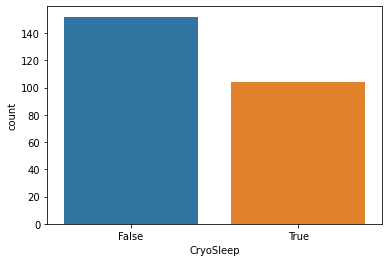

In [15]:
sns.countplot(traintest.query("Age == 0.0").CryoSleep)

The median is 27.0


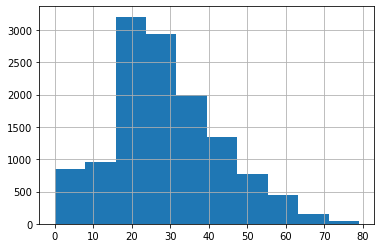

In [16]:
traintest.Age.hist()
print(f"The median is {traintest.Age.median()}")

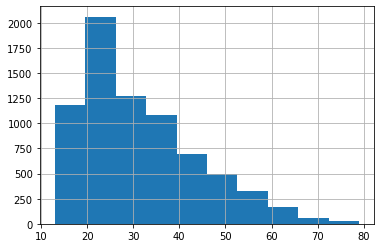

The median is 28.0
The minimum is 13.0


In [17]:
traintest.query("Expenses > 0.0").Age.hist()
plt.show()
print(f"The median is {traintest.query('Expenses > 0.0').Age.median()}")
print(f"The minimum is {traintest.query('Expenses > 0.0').Age.min()}")

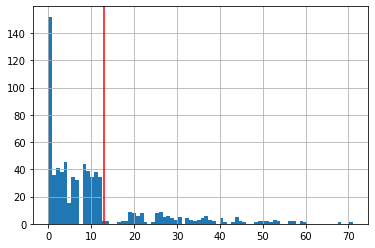

The median is 7.0


In [18]:
traintest.query("CryoSleep == False and Expenses == 0.0").Age.hist(bins = 80)
plt.axvline(13 ,c = "r")
plt.show()
print(f"The median is {traintest.query('CryoSleep == False and Expenses == 0.0').Age.median()}")

Seems like those under 13 are not allowed to spend, or somehow pay with their parents/guardians.
We can fill all those with zero expenses with nan Age to the median of 7.0. For those with nan as age but with expenses > 0, we can fill with median of 28.

In [19]:
traintest.loc[traintest["Age"].isnull() == True]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses
50,0052_01,Earth,False,G/6/S,TRAPPIST-1e,NaN,False,4.0,0.0,2.0,4683.0,0.0,Elaney Hubbarton,False,0052,01,G,6,S,Elaney,Hubbarton,4689.0
64,0068_01,Mars,False,E/4/S,TRAPPIST-1e,NaN,False,793.0,0.0,2.0,253.0,0.0,Cinst Binie,False,0068,01,E,4,S,Cinst,Binie,1048.0
137,0149_01,Earth,True,G/27/S,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Billya Hubbarrison,True,0149,01,G,27,S,Billya,Hubbarrison,0.0
181,0202_02,Europa,False,A/2/P,55 Cancri e,NaN,False,0.0,2433.0,NaN,878.0,443.0,Vegas Embleng,True,0202,02,A,2,P,Vegas,Embleng,3754.0
184,0206_01,Europa,False,C/9/S,55 Cancri e,NaN,False,2.0,1720.0,12.0,1125.0,122.0,Nuson Brugashed,True,0206,01,C,9,S,Nuson,Brugashed,2981.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12873,9065_01,Mars,True,F/1755/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jet Bart,NaN,9065,01,F,1755,S,Jet,Bart,0.0
12909,9147_01,Earth,True,G/1490/P,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Gabrin Meyersones,NaN,9147,01,G,1490,P,Gabrin,Meyersones,0.0
12922,9177_02,Europa,True,C/306/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Zedarga Vablug,NaN,9177,02,C,306,P,Zedarga,Vablug,0.0
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,01,D,296,P,Jayrin,Pore,0.0


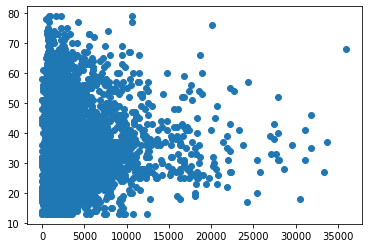

In [20]:
plt.scatter(traintest.query('Expenses > 0.0').Expenses.values , traintest.query('Expenses > 0.0').Age.values)

### VIP

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='VIP', ylabel='count'>

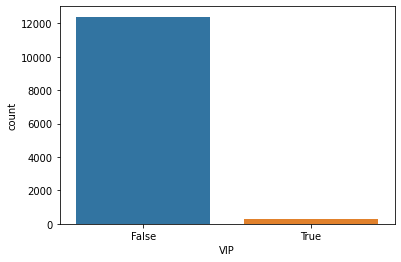

In [21]:
sns.countplot(traintest.VIP)


In [22]:
traintest.query("VIP == True").describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenses
count,271.000000,269.000000,267.000000,266.000000,269.000000,266.000000,273.000000
mean,36.664207,486.349442,1793.651685,273.680451,932.847584,1207.199248,4595.542125
std,11.203578,1058.272031,3593.931435,575.222273,2131.559126,2523.478754,5464.818112
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1299.000000
50%,33.000000,1.000000,280.000000,0.000000,46.000000,28.500000,2743.000000
75%,42.500000,600.000000,2167.500000,277.250000,928.000000,1281.000000,6206.000000
max,73.000000,8243.000000,29813.000000,3700.000000,15255.000000,19086.000000,33666.000000


In [23]:
traintest.query("VIP == False").describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenses
count,12142.000000,12149.000000,12123.000000,12107.000000,12125.000000,12142.000000,12401.00000
mean,28.589195,216.735698,419.522808,174.006608,292.849402,285.578406,1358.27651
std,14.393338,630.845068,1465.779835,595.481307,1090.430391,1116.953592,2655.51746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,704.00000
75%,37.000000,45.000000,59.000000,26.000000,50.000000,37.000000,1382.00000
max,79.000000,14327.000000,27071.000000,23492.000000,22408.000000,24133.000000,35987.00000


Clearly those with VIP passes are people who spend more. We can use the to fill the VIP column. VIPs also seem to be generally older individuals Expenses <1400 and Age <37 not VIP. We could even fill all with False for VIP as it is heavily skewed towards being False. 

### Cabins

In [24]:
traintest[traintest["Cabin"].isnull() == True].Destination.value_counts()

TRAPPIST-1e      204
55 Cancri e       64
PSO J318.5-22     27
Name: Destination, dtype: int64

In [25]:
pd.pivot_table(traintest, values='Age', index=['Destination'],
                    columns=['Cabin_0'], aggfunc="count")

Cabin_0,A,B,C,D,E,F,G,T
Destination,,,,,,,,
55 Cancri e,152.0,498.0,452.0,171.0,166.0,566.0,520.0,2.0
PSO J318.5-22,2.0,5.0,20.0,17.0,58.0,355.0,678.0,NaN
TRAPPIST-1e,185.0,594.0,586.0,503.0,1037.0,3144.0,2424.0,9.0


In [26]:
pd.pivot_table(traintest, values='PassengerId', index=['Destination'],
                    columns=['Cabin_2'], aggfunc="count")

Cabin_2,P,S
Destination,,
55 Cancri e,1242,1335
PSO J318.5-22,594,563
TRAPPIST-1e,4320,4347


In [27]:
pd.set_option("display.max_rows", 50)
traintest["PassengerId0_repeated"] = ""
traintest.PassengerId0_repeated = traintest.PassengerId_0.map(traintest.groupby('PassengerId_0')["PassengerId_0"].count() )
# traintest.query("PassengerId0_repeated > 1 ").groupby('PassengerId_0').agg(','.join)
traintest[(traintest["Cabin"].isnull() == True) & traintest["PassengerId0_repeated"] > 1]

# pd.set_option("display.max_rows", 20)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated


Seems like PassengerId wouldnt help impute Cabin nans. Cabin_0 filled with F if TRAPPIST-1e , G if PSO J318.5-22 , F if 55 Cancri e , else F could be used


### Destination

In [28]:
traintest[(traintest["Destination"].isnull() == True) & traintest["PassengerId0_repeated"].isnull() > 1 ]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated


In [29]:
traintest[(traintest["Destination"].isnull() == True)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated
47,0045_02,Mars,True,F/10/P,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,Mass Chmad,True,0045,02,F,10,P,Mass,Chmad,0.0,2
128,0138_02,Earth,False,E/5/P,NaN,34.0,False,0.0,22.0,0.0,564.0,207.0,Monah Gambs,False,0138,02,E,5,P,Monah,Gambs,793.0,2
139,0152_01,Earth,False,F/32/P,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,Andan Estron,False,0152,01,F,32,P,Andan,Estron,607.0,1
347,0382_01,NaN,False,G/64/P,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,Blanie Floydendley,False,0382,01,G,64,P,Blanie,Floydendley,720.0,1
430,0462_01,Earth,True,G/67/S,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,Ronia Sosanturney,False,0462,01,G,67,S,Ronia,Sosanturney,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,9022_03,Earth,True,F/1748/S,NaN,0.0,False,0.0,0.0,0.0,0.0,0.0,Erice Boyerson,NaN,9022,03,F,1748,S,Erice,Boyerson,0.0,3
12856,9039_01,Earth,True,G/1468/P,NaN,23.0,False,0.0,0.0,0.0,0.0,0.0,Nance Wilkinner,NaN,9039,01,G,1468,P,Nance,Wilkinner,0.0,1
12889,9095_01,Earth,False,G/1478/P,NaN,31.0,False,0.0,0.0,NaN,0.0,198.0,Lelah Reynoldez,NaN,9095,01,G,1478,P,Lelah,Reynoldez,198.0,1
12912,9155_01,Europa,False,C/304/P,NaN,17.0,False,149.0,2045.0,NaN,1872.0,0.0,Markar Amoutake,NaN,9155,01,C,304,P,Markar,Amoutake,4066.0,4


In [30]:
pd.pivot_table(traintest, values='PassengerId', index=['Cabin_0'],
                    columns=['Destination'], aggfunc="count")

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Cabin_0,,,
A,157.0,2.0,190.0
B,507.0,5.0,606.0
C,465.0,20.0,596.0
D,175.0,17.0,513.0
E,166.0,58.0,1064.0
F,572.0,362.0,3209.0
G,533.0,693.0,2480.0
T,2.0,NaN,9.0


In [31]:
pd.pivot_table(traintest, values='PassengerId', index=['Cabin_2'],
                    columns=['Destination'], aggfunc="count")

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
Cabin_2,,,
P,1242,594,4320
S,1335,563,4347


In [32]:
pd.pivot_table(traintest, values='PassengerId', index=['HomePlanet'],
                    columns=['Destination'], aggfunc="count")

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,984,1065,4672
Europa,1310,29,1737
Mars,294,67,2256


Seems like no quick rules to create to impute **Destination**

### HomePlanet

In [33]:
traintest[(traintest["HomePlanet"].isnull() == True)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True,0064,02,E,3,S,Colatz,Keen,0.0,2
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,0119,01,A,0,P,Batan,Coning,9307.0,2
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,0210,01,D,6,P,Arraid,Inicont,0.0,1
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,0242,01,F,46,S,Almone,Sté,1288.0,1
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,0251,01,C,11,S,Diphah,Amsive,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,0.0,0.0,Vanley Simmonders,NaN,8621,01,E,552,P,Vanley,Simmonders,1608.0,1
12673,8678_01,NaN,True,G/1399/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Eilan Kellson,NaN,8678,01,G,1399,S,Eilan,Kellson,0.0,2
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,Raston Maltorted,NaN,8775,01,D,275,P,Raston,Maltorted,0.0,1
12852,9025_01,NaN,False,G/1454/S,TRAPPIST-1e,42.0,False,0.0,0.0,28.0,726.0,0.0,Ale Whitersone,NaN,9025,01,G,1454,S,Ale,Whitersone,754.0,2


In [34]:
pd.pivot_table(traintest, values='PassengerId', index=['Cabin_2'],
                    columns=['HomePlanet'], aggfunc="count")

HomePlanet,Earth,Europa,Mars
Cabin_2,,,
P,3382,1450,1330
S,3327,1604,1297


In [35]:
pd.pivot_table(traintest, values='PassengerId', index=['Cabin_0'],
                    columns=['HomePlanet'], aggfunc="count")

HomePlanet,Earth,Europa,Mars
Cabin_0,,,
A,NaN,346.0,NaN
B,NaN,1124.0,NaN
C,NaN,1081.0,NaN
D,NaN,296.0,406.0
E,583.0,197.0,508.0
F,2426.0,NaN,1713.0
G,3700.0,NaN,NaN
T,NaN,10.0,NaN


In [36]:
pd.pivot_table(traintest, values='PassengerId', index=['Destination'],
                    columns=['HomePlanet'], aggfunc="count")

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,984,1310,294
PSO J318.5-22,1065,29,67
TRAPPIST-1e,4672,1737,2256


In [37]:
pd.pivot_table(traintest, values='PassengerId', index=['VIP'],
                    columns=['HomePlanet'], aggfunc="count")

HomePlanet,Earth,Europa,Mars
VIP,,,
False,6706.0,2883.0,2533.0
True,NaN,177.0,90.0


In [38]:
mapper_homeplant = {"A":"Europa" , "B":"Europa","C":"Europa" ,"G":"Earth" , "T":"Europa"}
# mapper_homeplant_1 = {False: "Earth" , True:"Europa"}

Seems like we can make some kind of dict to map by using Cabin_0 to impute HomePlanet. We can also see that Earthlings do not get a VIP pass often, however am not gonna create any rules based on this fact and ill let the imputer later impute missing values here.

Check if persons from other plants are on average older or if they spend more

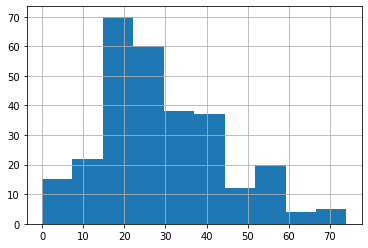

Median age of nans:26.0
Median age of non nans:27.0


In [39]:
traintest[(traintest["HomePlanet"].isnull() == True)].Age.hist()
plt.show()
print(f"Median age of nans:{traintest[(traintest['HomePlanet'].isnull() == True)].Age.median()}")
print(f"Median age of non nans:{traintest.Age.median()}")

Median expenses of nans:737.0
Median expenses of non nans:716.0


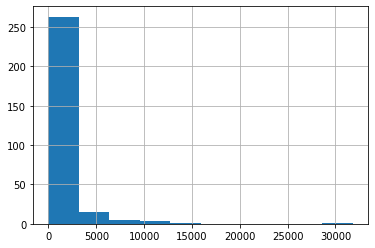

In [40]:
traintest[(traintest["HomePlanet"].isnull() == True)].Expenses.hist()
print(f"Median expenses of nans:{traintest[(traintest['HomePlanet'].isnull() == True)].Expenses.median()}")
print(f"Median expenses of non nans:{traintest.Expenses.median()}")

In [41]:
traintest[(traintest["HomePlanet"].isnull() == True) & traintest["PassengerId0_repeated"].isnull() > 1 ]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated


So lets summerize the missing value imputation rules we created so far:
- If Expenses = 0 then CryoSleep = True else False
- If Expenses = 0 then Age = 7. If expenses > 0 then Age = 27 
- If Expenses < 1400 & Age < 37 then not VIP Else VIP
- Use mapper_homeplanet to Impute HomePlanet using Cabin_0.

In [42]:
traintest

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P,Maham,Ofracculy,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S,Juanna,Vines,736.0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S,Altark,Susent,10383.0,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S,Solam,Susent,5176.0,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S,Willy,Santantines,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,02,G,1496,S,Jeron,Peter,0.0,2
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron,1018.0,1
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,01,D,296,P,Jayrin,Pore,0.0,1
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,01,D,297,P,Kitakan,Conale,3203.0,1


In [43]:
def cryosleep_nan(row):
    if row['Expenses'] == 0.0:
        return True
    else: 
        return False

traintest.loc[traintest["CryoSleep"].isnull() == True , "CryoSleep"] = traintest.apply(lambda row:cryosleep_nan(row), axis=1 )
traintest.loc[(traintest["Expenses"]== 0.0)&(traintest["Age"].isnull()) , "Age"] = traintest.query('CryoSleep == False and Expenses == 0.0').Age.median()
traintest.loc[(traintest["Expenses"] > 0.0) &(traintest["Age"].isnull())  ,"Age"] = traintest.query('Expenses > 0.0').Age.median()
traintest.loc[(traintest["Expenses"]<1400)&(traintest["Age"]<37)&(traintest["VIP"].isnull())  , "VIP"] = False
traintest.loc[traintest["VIP"].isnull() , "VIP"] = True
traintest.loc[traintest["HomePlanet"].isnull(), "HomePlanet"] = traintest.Cabin_0.map(mapper_homeplant)
traintest["cabin_count"] = traintest.Cabin_1.map(traintest.groupby("Cabin_1")["Cabin_1"].count())
traintest["passengerId_count"] = traintest.PassengerId_0.map(traintest.groupby("PassengerId_0")["PassengerId_0"].count() ) 
traintest.loc[traintest.Expenses == 0.0, "did_spend"]  = False
traintest.loc[traintest.Expenses > 0.0 , "did_spend"] = True 
traintest.loc[traintest.Age == 0.0 , "age_zero"] = True
traintest.loc[traintest.Age > 0.0 , "age_zero"] = False
traintest.loc[traintest.Age <13.0 , "is_minor"] = True
traintest.loc[traintest.Age >= 13.0, "is_minor"] = False 
traintest["age_bin"] = pd.cut(traintest["Age"], bins=10, labels=False)
# traintest.loc[(traintest["Age"] == 0.0) & (traintest["Expenses"] == 0.0) ,"Age"] = traintest.query('CryoSleep == False and Expenses == 0.0').Age.median()


In [44]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            12970 non-null  object 
 1   HomePlanet             12810 non-null  object 
 2   CryoSleep              12970 non-null  object 
 3   Cabin                  12671 non-null  object 
 4   Destination            12696 non-null  object 
 5   Age                    12970 non-null  float64
 6   VIP                    12970 non-null  object 
 7   RoomService            12707 non-null  float64
 8   FoodCourt              12681 non-null  float64
 9   ShoppingMall           12664 non-null  float64
 10  Spa                    12686 non-null  float64
 11  VRDeck                 12702 non-null  float64
 12  Name                   12676 non-null  object 
 13  Transported            8693 non-null   object 
 14  PassengerId_0          12970 non-null  object 
 15  Pa

In [45]:
traintest

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_0,PassengerId_1,Cabin_0,Cabin_1,Cabin_2,Name_0,Name_1,Expenses,PassengerId0_repeated,cabin_count,passengerId_count,did_spend,age_zero,is_minor,age_bin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P,Maham,Ofracculy,0.0,1,25.0,1,False,False,False,4
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S,Juanna,Vines,736.0,1,25.0,1,True,False,False,3
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S,Altark,Susent,10383.0,2,25.0,2,True,False,False,7
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S,Solam,Susent,5176.0,2,25.0,2,True,False,False,4
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S,Willy,Santantines,1091.0,1,20.0,1,True,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,9266,02,G,1496,S,Jeron,Peter,0.0,2,5.0,2,False,False,False,4
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron,1018.0,1,NaN,1,True,False,False,5
12967,9271_01,Mars,True,D/296/P,55 Cancri e,7.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,9271,01,D,296,P,Jayrin,Pore,0.0,1,13.0,1,False,False,True,0
12968,9273_01,Europa,False,D/297/P,NaN,28.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,9273,01,D,297,P,Kitakan,Conale,3203.0,1,14.0,1,True,False,False,3


In [46]:
# features = test.columns ### For now assuming all column names other than the target are features
target = "Transported" ### Change to the column name of the target variable
numeric_features = ["Age", 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , "PassengerId_0", "Expenses"  ,"cabin_count" ,"passengerId_count"  ] ### Add all numeric features
categorical_features = ["HomePlanet" , "CryoSleep" ,"Destination" ,"VIP","PassengerId_1" ,"Cabin_0" , "Cabin_2" ,"did_spend" ,"age_zero" , "is_minor" , "age_bin"]
traintest[numeric_features] = traintest[numeric_features].astype("float")

## EDA

<AxesSubplot:>

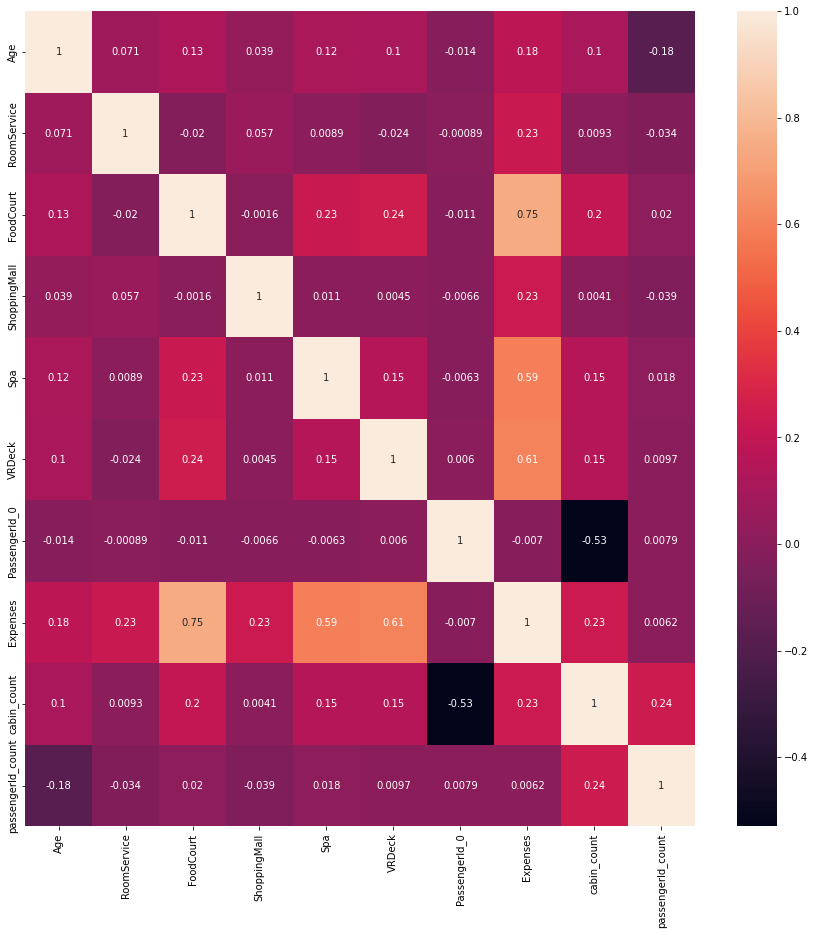

In [47]:
plt.figure(figsize = (15,15))
sns.heatmap(traintest[numeric_features].corr(),annot = True) ### check for any high values, will be addressed later

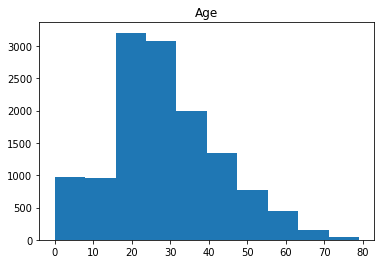

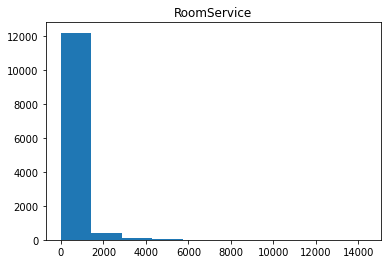

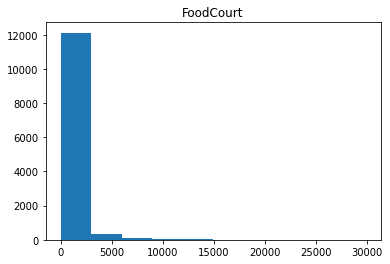

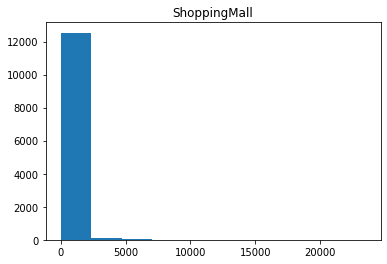

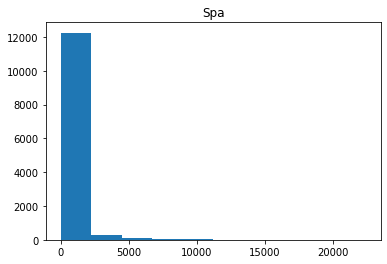

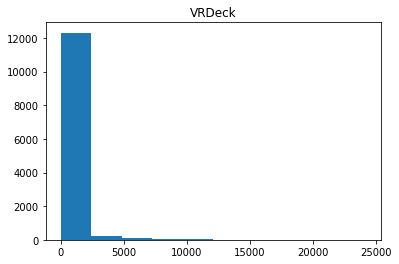

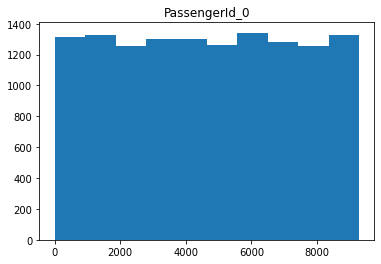

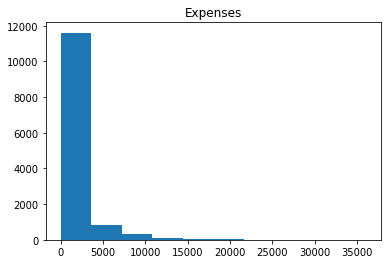

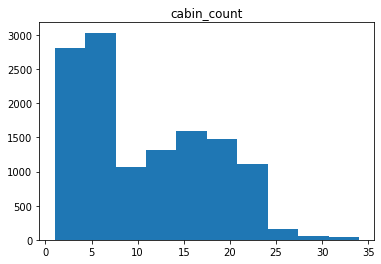

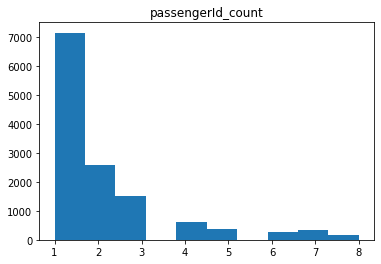

In [48]:
for i in numeric_features: ### Check for skwenness 
    plt.title(f"{i}")
    plt.hist(traintest[f"{i}"])
    plt.show()
remove_skewness =[ 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , "Expenses" ]

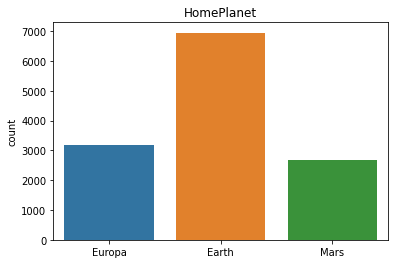

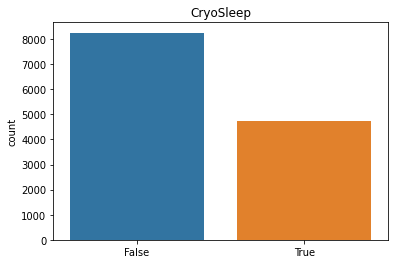

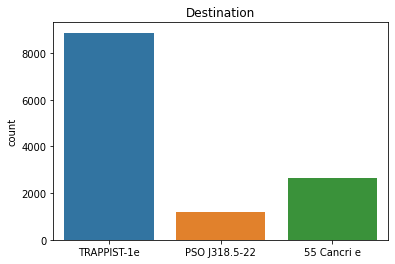

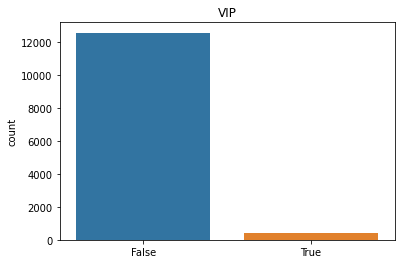

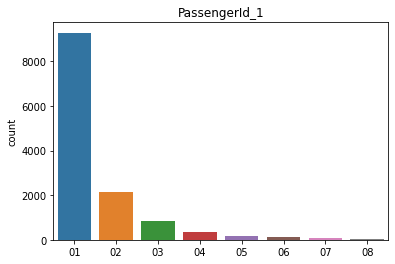

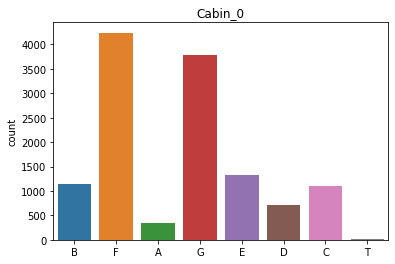

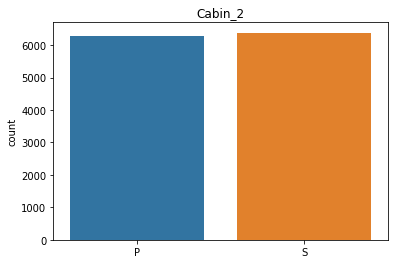

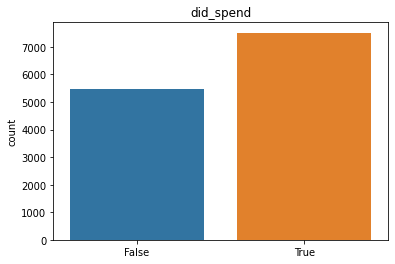

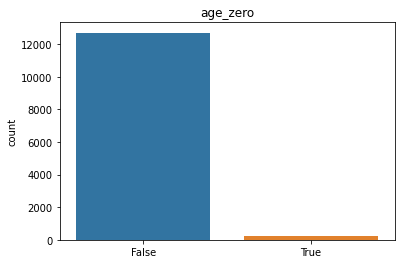

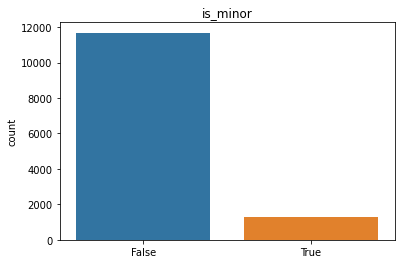

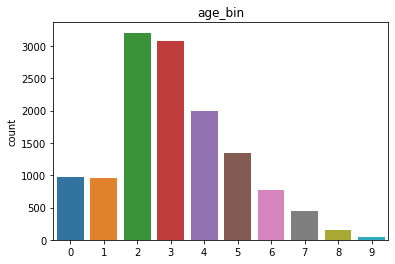

In [49]:
for i in list(categorical_features):
    plt.title(i)
    sns.countplot(x = traintest[f"{i}"].values)
    plt.show()

## Time to work on the data!!

### Fix skeweness of numeric data

In [50]:
for i in remove_skewness:
    traintest[i] = np.sqrt(traintest[i])

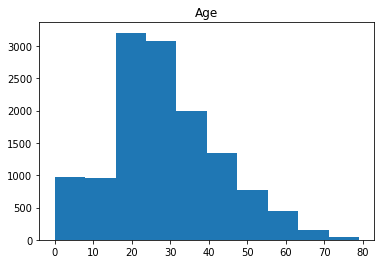

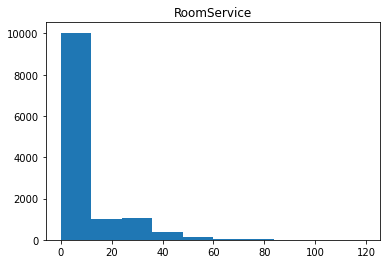

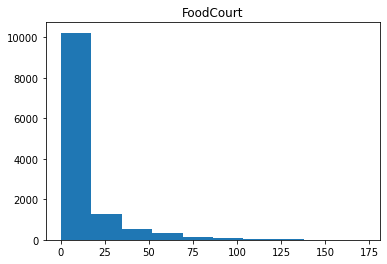

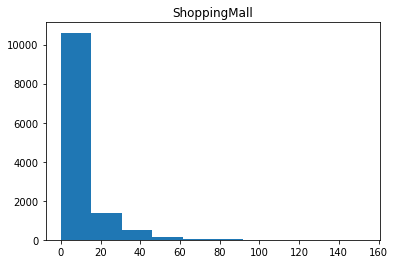

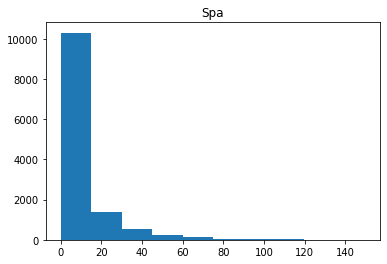

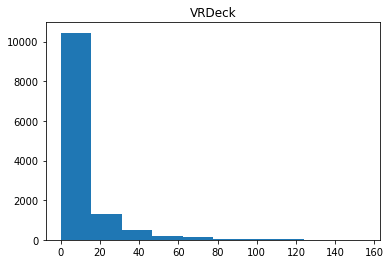

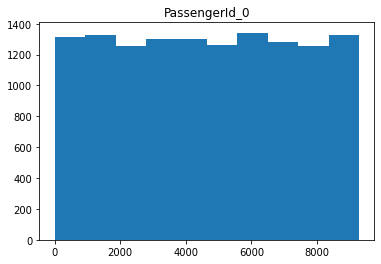

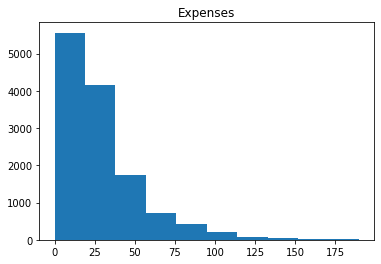

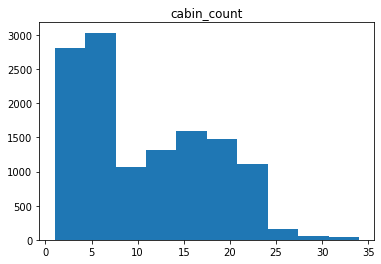

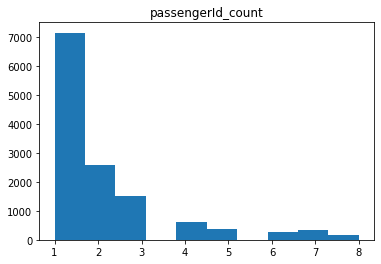

In [51]:
for i in numeric_features: ### Check for skwenness 
    plt.title(f"{i}")
    plt.hist(traintest[f"{i}"])
    plt.show()
remove_skewness =[ 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' , "Expenses" ]

In [52]:
## check if target is skewed

In [53]:
# imputer = SimpleImputer(strategy = "mean")
# traintest.loc[:,numeric_features] = imputer.fit_transform(traintest.loc[:,numeric_features].values)
# # test.loc[:,numeric_features] = imputer.transform(test.loc[:,numeric_features].values)
# imputer = SimpleImputer(strategy = "most_frequent")
# traintest.loc[:,categorical_features] = imputer.fit_transform(traintest.loc[:,categorical_features].values)
# # test.loc[:,categorical_features]= imputer.fit_transform(test.loc[:,categorical_features].values)

### Check colinearity 

In [54]:
# #check colinearity
# #Compute VIF data for each independent variable
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif["features"] = traintest[numeric_features].columns
# vif["vif_Factor"] = [variance_inflation_factor(traintest[numeric_features].values, i) for i in range(traintest[numeric_features].shape[1])]
# vif
# #>10 not so good

In [55]:
# #feature engineer
# from headjackai.headjackai_hub import headjackai_hub

# #host setting
# hj_hub = headjackai_hub('http://www.headjackai.com:9000')
# hj_hub.login(username='jimliu_kaggle', pwd='12345678')
# hj_hub.knowledgepool_check(public_pool=True)
# source = 'drug_type'


# best_features = [
#  'Spaceship-Titanic-CryoSleep',
#  'Spaceship-Titanic-RoomService',
#  'Spaceship-Titanic-Spa',
#  'Spaceship-Titanic-VRDeck',
#  'Spaceship-Titanic-deck',
#  'Spaceship-Titanic-side',
#  'Spaceship-Titanic-SumSpends',
#  'drug_type-Sex']


# # run features engineering on hj 
# hj_X = hj_hub.knowledge_transform(data=train, target_domain='Spaceship-Titanic', 
#                                   source_domain=source,
#                                   label='')

# hj_ts_X = hj_hub.knowledge_transform(data=test, target_domain='Spaceship-Titanic', 
#                                   source_domain=source,
#                                   label='') 

### Encode, impute missing values and scale

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
labenc = LabelEncoder()
labenc.fit(traintest.loc[traintest[target].isnull() == False ,target].unique())

traintest.loc[traintest[target].isnull() == False ,target] = \
labenc.transform(traintest.loc[traintest[target].isnull() == False ,target])
for i in categorical_features:
    enc = LabelEncoder()
    traintest.loc[traintest[i].isnull() == False, i] = enc.fit_transform(traintest.loc[traintest[i].isnull() == False, i].values)
imputer = KNNImputer()
traintest[numeric_features+categorical_features] = imputer.fit_transform(traintest[numeric_features+categorical_features].values)
scaler = StandardScaler()
traintest[numeric_features+categorical_features] = scaler.fit_transform(traintest[numeric_features+categorical_features].values)

### Feature engineering time 

## Time for some ML

In [57]:
# features_isolation =numeric_features+categorical_features
# from sklearn.ensemble import IsolationForest

# isf = IsolationForest(n_jobs=-1, random_state=1,n_estimators=100,contamination=0.002)
# isf.fit(traintest.loc[features_isolation], traintest[target])

# rows = pd.DataFrame(isf.predict(traintest[features_isolation]),columns=['feature'])
# rows_ind = rows[rows.feature == 1]
# results = pd.DataFrame()
# results['results'] = - isf.score_samples(traintest[features_isolation])
# results['chance'] = isf.decision_function(traintest[features_isolation])
# results['yes/no'] = isf.predict(traintest[features_isolation])

# new = results[results['yes/no']==1]
# old= results[results['yes/no']==-1]
# fig,ax = plt.subplots(figsize=(20,10))
# ax.set_facecolor('black')
# ax = plt.scatter(new.index,new.results,marker=".")
# ax = plt.scatter(old.index,old.results,color='white',marker="*")

### split into features and targets for the models

In [58]:
x = traintest.loc[traintest["Transported"].isnull() == False  , numeric_features +categorical_features].values
y = traintest.loc[traintest["Transported"].isnull() == False  , target].values
x_test = traintest.loc[traintest["Transported"].isnull() == True  , numeric_features +categorical_features].values
y=y.astype('int')
x = x.astype("float64")
x_test = x_test.astype("float64")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### Select all the models needed

In [59]:
import xgboost as xgb
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 725, #initial value is 651
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}
classifiers = [

RandomForestClassifier(),
AdaBoostClassifier(),
GradientBoostingClassifier(),
ExtraTreesClassifier(),
LinearDiscriminantAnalysis(),
LogisticRegression(),
KNeighborsClassifier(),
DecisionTreeClassifier(),
MLPClassifier(),
CatBoostClassifier(verbose = False),
SVC()
]

### Running through all and cross validating  

In [60]:
model_results_columns = ['fit_time', 'score_time', 'test_accuracy', 'train_accuracy',
       'test_precision', 'train_precision', 'test_recall', 'train_recall',
       'test_r2', 'train_r2', 'test_neg_mean_squared_error',
       'train_neg_mean_squared_error']
model_results_df = pd.DataFrame([], columns = model_results_columns)
for clf in tqdm(classifiers):
    model = cross_validate(clf , x, y , cv= 10,\
                           scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True)
    model_results_df = pd.concat([model_results_df,pd.DataFrame(pd.DataFrame(model).describe().loc["mean" ,:]).rename(columns = {"mean":str(clf).split("(")[0]}).transpose()], axis = 0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

### Analyse results
For the **overfitting** column, the closer to zero the better

In [61]:
model_results_df["overfitting"] =(1-(model_results_df["test_accuracy"]/ model_results_df["train_accuracy"]))*100
model_results_df.sort_values("test_accuracy", ascending = False)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,overfitting
SVC,2.307276,0.231727,0.800535,0.819651,0.795643,0.812139,0.814769,0.835084,0.202099,0.278565,-0.199465,-0.180349,2.332128
MLPClassifier,16.390719,0.008323,0.796626,0.847016,0.815665,0.854797,0.778697,0.838917,0.186459,0.388033,-0.203374,-0.152984,5.949194
LogisticRegression,0.069801,0.006923,0.793630,0.795698,0.774051,0.775339,0.835550,0.836810,0.174478,0.182748,-0.206370,-0.204302,0.259808
ExtraTreesClassifier,0.945655,0.044030,0.792827,1.000000,0.826868,1.000000,0.746481,1.000000,0.171266,1.000000,-0.207173,0.000000,20.717260
LinearDiscriminantAnalysis,0.063953,0.007575,0.792826,0.795404,0.782331,0.784113,0.817506,0.819349,0.171262,0.181572,-0.207174,-0.204596,0.324027
RandomForestClassifier,1.200352,0.035883,0.790069,0.999987,0.821976,1.000000,0.748996,0.999975,0.160231,0.999949,-0.209931,-0.000013,20.992112
KNeighborsClassifier,0.001844,0.222990,0.781324,0.848537,0.791913,0.856834,0.769320,0.839526,0.125251,0.394117,-0.218676,-0.151463,7.921021
GradientBoostingClassifier,1.556211,0.005303,0.766827,0.822220,0.789680,0.805493,0.754697,0.853002,0.067260,0.288842,-0.233173,-0.177780,6.736961
AdaBoostClassifier,0.491210,0.018137,0.747723,0.798305,0.786868,0.775208,0.729597,0.844373,-0.009161,0.193179,-0.252277,-0.201695,6.336157
<catboost.core.CatBoostClassifier object at 0x7f3b3b810150>,4.769462,0.010582,0.715743,0.886090,0.744801,0.883452,0.721764,0.891427,-0.137086,0.544335,-0.284257,-0.113910,19.224582


### Combine models

In [62]:
# model = VotingClassifier([('cbc',CatBoostClassifier(verbose = False)) , ('svc',SVC()),('gbc',GradientBoostingClassifier())] , voting = "hard")

In [63]:

# re = cross_validate(model , x, y , cv= 10,\
#                            scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True)

### Hyperparameter tuning

In [64]:
hp = {
    "criterion":['gini', 'entropy'],
    "splitter":["best" ,"random"],
    "min_samples_split":[1.0,2,3,4]
}
# hp = {
#     "hidden_layer_sizes":[50,100,200,300,1000],
#     "activation":['identity', 'logistic', 'tanh', 'relu'],
#     "solver":["lbfgs" , 'sgd','adam'],
#     "alpha":[0.0001,0.001,0.01,0.00001],
#     "learning_rate":["constant" , "invscaling" ,"adapting"],
#     "learning_rate_init":[0.1,0.01,0.001,0.0001],
#     "max_iter":[20000]
    
# }
params_RandomForestClassifier = {
    "n_estimators":[10,100,200,400],
#     "criterion":['gini', 'entropy'],
#     "max_depth":[100,10,None],
#     "max_features":["sqrt" , "log2" , None],
}
params_catboost = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }    




In [65]:
# from sklearn.experimental import enable_halving_search_cv 
# from sklearn.model_selection import HalvingGridSearchCV
# sh = HalvingGridSearchCV(model, params_catboost, cv=10,verbose = 2, scoring = "accuracy").fit(x, y)

## Choose the best model to fit and then predict on test

In [66]:
model = SVC()

In [67]:
re = pd.DataFrame(cross_validate(model , x, y , cv= 10,\
                           scoring=('accuracy' , 'precision', 'recall' , 'r2', 'neg_mean_squared_error'),return_train_score=True))

In [68]:
re.test_accuracy.mean()

0.8005352962184039

In [69]:
model.fit(X_train,y_train)

SVC()

In [70]:
preds = model.predict(x_test) 

In [71]:
pd.concat([test.reset_index() , pd.DataFrame(labenc.inverse_transform(preds), columns = ["Transported"])], axis = 1)[["PassengerId", "Transported"]]

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


## Download submission.csv

In [72]:
pd.concat([test.reset_index() , pd.DataFrame(labenc.inverse_transform(preds), columns = ["Transported"])], axis = 1)[["PassengerId", "Transported"]].to_csv("submission.csv", index = False)